# 🌗 Partial Ring Attractor with Symmetry Regularization

This notebook demonstrates the power of symmetry regularization when learning from **partial/limited data**.

**Key experimental manipulations:**
- **Undersampled Ring**: Only observe trajectories from ~half the ring (e.g., right semicircle)
- **Degraded Observations**: Weaker readout matrix `C` + higher noise
- **Symmetry Rescue**: Can rotational symmetry help XFADS generalize to the full ring?

**Hypothesis**: 
- Without regularization: XFADS learns good ELBO but incomplete/asymmetric dynamics
- With regularization: Symmetry constraints help recover the full ring structure

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
# Setup
startupMode = 'dev'

if startupMode == 'dev':
    import sys
    sys.path.append('../..')
    config_path = ''

In [111]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import numpy as np
from pathlib import Path

import xfads.utils as utils
import xfads.plot_utils as plot_utils

from hydra import compose, initialize
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Timer
from xfads.ssm_modules.dynamics import DenseGaussianDynamics
from xfads.ssm_modules.likelihoods import GaussianLikelihood
from xfads.ssm_modules.dynamics import DenseGaussianInitialCondition
from xfads.ssm_modules.encoders import LocalEncoderLRMvn, BackwardEncoderLRMvn
from xfads.smoothers.lightning_trainers import LightningNonlinearSSM
from xfads.smoothers.nonlinear_smoother import NonlinearFilterSmallL

# Import regularized SSM
from regularized_ssm import RegularizedSSM, RegularizedLightningSSM, create_rotation_vector_field

## ⚙️ Initialize Configuration

In [112]:
from hydra.core.global_hydra import GlobalHydra
if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()

initialize(version_base=None, config_path=config_path, job_name="lds")
cfg = compose(config_name="config")

pl.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)
torch.cuda.empty_cache()

Seed set to 1234


In [113]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

cfg['device'] = device
print(f"Using device: {device}")

cfg['n_epochs'] = 25
print(f"Training for {cfg['n_epochs']} epochs")

Using device: cpu
Training for 25 epochs


## 🌗 Generate Partial Ring Data

We'll create a dataset that only samples from part of the ring (e.g., right semicircle).

In [114]:
import importlib.util

file_path = "test_dynamics.py"
module_name = "test_dynamics"

spec = importlib.util.spec_from_file_location(module_name, file_path)
test_dynamics = importlib.util.module_from_spec(spec)
spec.loader.exec_module(test_dynamics)
PerturbedRingAttractorDynamics = test_dynamics.PerturbedRingAttractorRNN

In [115]:
# Data generation parameters
perturbation_magnitude = 0.1
n_trials = 1000  # More trials to compensate for filtering
n_neurons = 100   # Fewer neurons (degraded observations)
n_time_bins = 75

print(f"🎯 Generating partial ring data:")
print(f"  Perturbation magnitude: {perturbation_magnitude}")
print(f"  Total trials: {n_trials}")
print(f"  Neurons: {n_neurons}")
print(f"  Time bins: {n_time_bins}")

🎯 Generating partial ring data:
  Perturbation magnitude: 0.1
  Total trials: 1000
  Neurons: 100
  Time bins: 75


In [116]:
# Generate full ring data first
mean_fn = PerturbedRingAttractorDynamics(
    bin_sz=1e-1, 
    lengthscale=0.2, 
    perturbation_magnitude=perturbation_magnitude
).to(cfg.device)

# Weaker/noisier readout matrix
C_strength = 1.0  # Reduce readout strength 
C = utils.FanInLinear(cfg.n_latents, n_neurons, device=cfg.device).requires_grad_(False)
# Scale down the readout matrix to make observations less informative
with torch.no_grad():
    C.weight *= C_strength
    C.bias *= C_strength

# Higher noise levels
Q_diag = 8e-3 * torch.ones(cfg.n_latents, device=cfg.device)  # Higher process noise
Q_0_diag = 1.2 * torch.ones(cfg.n_latents, device=cfg.device)  # Higher init noise
R_diag = 5e-4 * torch.ones(n_neurons, device=cfg.device)     # Higher observation noise
m_0 = torch.zeros(cfg.n_latents, device=cfg.device)

print(f"\n📉 Degraded observation setup:")
print(f"  Readout strength: {C_strength} (scaled down)")
print(f"  Process noise: {Q_diag[0].item():.2e} (increased)")
print(f"  Observation noise: {R_diag[0].item():.2e} (increased)")


📉 Degraded observation setup:
  Readout strength: 1.0 (scaled down)
  Process noise: 8.00e-03 (increased)
  Observation noise: 5.00e-04 (increased)


In [117]:
# Sample trajectories
z_all = utils.sample_gauss_z(mean_fn, Q_diag, m_0, Q_0_diag, n_trials, n_time_bins)
y_all = C(z_all) + torch.sqrt(R_diag) * torch.randn((n_trials, n_time_bins, n_neurons), device=cfg.device)
y_all = y_all.detach()

print(f"Generated full dataset: {z_all.shape}, {y_all.shape}")

Generated full dataset: torch.Size([1000, 75, 2]), torch.Size([1000, 75, 100])


In [118]:
# Filter to partial ring: only keep trajectories that spend time in right semicircle
def filter_to_partial_ring(z_trajectories, y_trajectories, region="right", min_time_fraction=0.3):
    """
    Filter trajectories to only include those that spend significant time in a specific region.
    
    Args:
        z_trajectories: (n_trials, n_time, 2)
        y_trajectories: (n_trials, n_time, n_neurons)
        region: "right", "left", "upper", "lower"
        min_time_fraction: minimum fraction of time that must be spent in region
    """
    n_trials, n_time = z_trajectories.shape[:2]
    
    valid_trials = []
    
    for trial in range(n_trials):
        traj = z_trajectories[trial]  # (n_time, 2)
        x, y = traj[:, 0], traj[:, 1]
        
        if region == "right":
            in_region = x > 0  # Right half-plane
        elif region == "left":
            in_region = x < 0  # Left half-plane
        elif region == "upper":
            in_region = y > 0  # Upper half-plane
        elif region == "lower":
            in_region = y < 0  # Lower half-plane
        else:
            raise ValueError(f"Unknown region: {region}")
        
        time_fraction = in_region.float().mean().item()
        
        if time_fraction >= min_time_fraction:
            valid_trials.append(trial)
    
    print(f"Found {len(valid_trials)}/{n_trials} trials spending ≥{min_time_fraction:.1%} time in {region} region")
    
    return z_trajectories[valid_trials], y_trajectories[valid_trials]

# Filter to right semicircle
z_partial, y_partial = filter_to_partial_ring(z_all, y_all, region="right", min_time_fraction=0.1)

print(f"\n🌗 Partial ring dataset:")
print(f"  Latent shape: {z_partial.shape}")
print(f"  Observation shape: {y_partial.shape}")
print(f"  Kept {z_partial.shape[0]}/{n_trials} trials ({100*z_partial.shape[0]/n_trials:.1f}%)")

Found 581/1000 trials spending ≥10.0% time in right region

🌗 Partial ring dataset:
  Latent shape: torch.Size([581, 75, 2])
  Observation shape: torch.Size([581, 75, 100])
  Kept 581/1000 trials (58.1%)


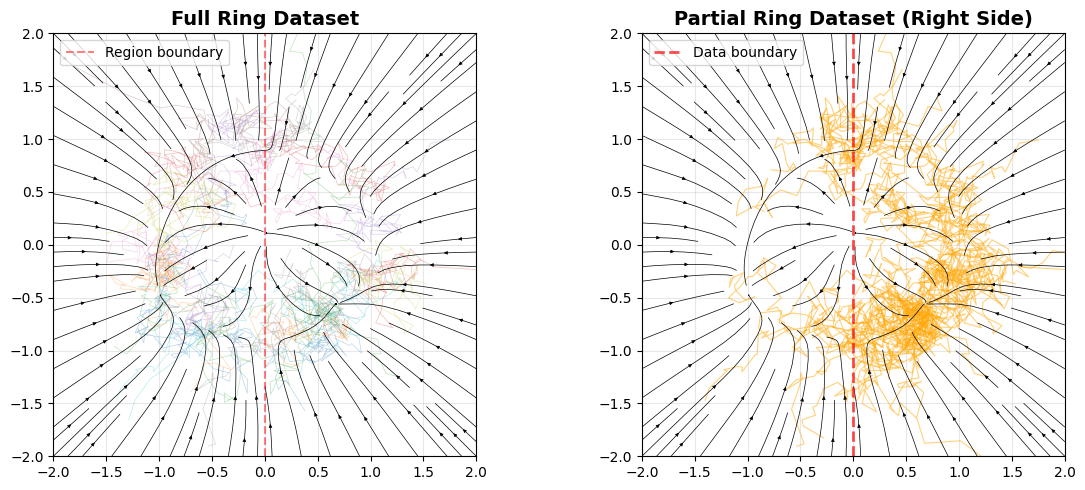

🎯 Key observation: Training data is heavily biased toward right semicircle!
   Can symmetry regularization help recover the full ring structure?


In [119]:
# Visualize the partial ring sampling
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Full dataset
axes[0].set_title("Full Ring Dataset", fontsize=14, fontweight='bold')
for i in range(min(30, z_all.shape[0])):
    axes[0].plot(z_all[i, :, 0].cpu(), z_all[i, :, 1].cpu(), alpha=0.3, linewidth=0.5)
plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), axes[0], min_xy=-2, max_xy=2)
axes[0].set_xlim(-2, 2)
axes[0].set_ylim(-2, 2)
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=0, color='red', linestyle='--', alpha=0.5, label='Region boundary')
axes[0].legend()

# Partial dataset (right side only)
axes[1].set_title("Partial Ring Dataset (Right Side)", fontsize=14, fontweight='bold')
for i in range(min(30, z_partial.shape[0])):
    axes[1].plot(z_partial[i, :, 0].cpu(), z_partial[i, :, 1].cpu(), 'orange', alpha=0.5, linewidth=0.8)
plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), axes[1], min_xy=-2, max_xy=2)
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Data boundary')
axes[1].legend()

plt.tight_layout()
plt.show()

print("🎯 Key observation: Training data is heavily biased toward right semicircle!")
print("   Can symmetry regularization help recover the full ring structure?")

## 🔄 Prepare Dataloaders

In [120]:
def collate_fn(batch):
    elem = batch[0]
    if isinstance(elem, (tuple, list)):
        return tuple(torch.stack([b[i] for b in batch]).to(cfg.device) for i in range(len(elem)))
    else:
        return torch.stack(batch).to(cfg.device)

# Use the partial dataset for training
z, y = z_partial, y_partial

# Split data
split_idx = 2 * z.shape[0] // 3
y_train, z_train = y[:split_idx], z[:split_idx]
y_valid, z_valid = y[split_idx:], z[split_idx:]

print(f"Partial ring training data: {y_train.shape}")
print(f"Partial ring validation data: {y_valid.shape}")

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_train), 
    batch_size=cfg.batch_sz, 
    shuffle=True, 
    collate_fn=collate_fn
)
valid_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(y_valid), 
    batch_size=cfg.batch_sz, 
    shuffle=False, 
    collate_fn=collate_fn
)

Partial ring training data: torch.Size([387, 75, 100])
Partial ring validation data: torch.Size([194, 75, 100])


## 🧱 Define Model Components

In [121]:
# Likelihood (degraded observations)
H = utils.ReadoutLatentMask(cfg.n_latents, cfg.n_latents_read)
readout_fn = nn.Sequential(H, C)
likelihood_pdf = GaussianLikelihood(readout_fn, n_neurons, R_diag, device=cfg.device, fix_R=True)

# Dynamics (learnable)
dynamics_fn = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod = DenseGaussianDynamics(dynamics_fn, cfg.n_latents, Q_diag, device=cfg.device)

# Initial condition
initial_condition_pdf = DenseGaussianInitialCondition(cfg.n_latents, m_0, Q_0_diag, device=cfg.device)

# Encoders
backward_encoder = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)

# Nonlinear filtering
nl_filter = NonlinearFilterSmallL(dynamics_mod, initial_condition_pdf, device=cfg.device)

print("✅ Model components created (degraded observations)")
print(f"  Readout matrix strength: {C_strength}")
print(f"  Observation noise: {R_diag[0].item():.2e}")
print(f"  Process noise: {Q_diag[0].item():.2e}")

✅ Model components created (degraded observations)
  Readout matrix strength: 1.0
  Observation noise: 5.00e-04
  Process noise: 8.00e-03


## 🎯 Define Target Vector Field for Regularization

Target vector field test:
  Input shape: torch.Size([10, 2])
  Output shape: torch.Size([10, 2])


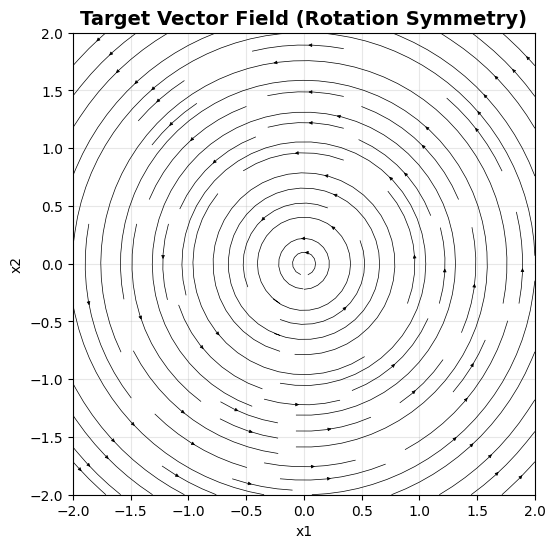

✅ Rotation symmetry target field created
   This should help generalize beyond the partial training data!


In [122]:
# Create target vector field (rotation)
target_vector_field = create_rotation_vector_field(rotation_speed=0.5)

# Test the target field
test_points = torch.randn(10, 2)
test_output = target_vector_field(test_points)
print(f"Target vector field test:")
print(f"  Input shape: {test_points.shape}")
print(f"  Output shape: {test_output.shape}")

# Visualize target field (rotation)
fig, ax = plt.subplots(figsize=(6, 6))
dt = 1e-2
plot_utils.plot_two_d_vector_field(
    lambda x: x + dt * target_vector_field(x), ax, min_xy=-2, max_xy=2
)
ax.set_title("Target Vector Field (Rotation Symmetry)", fontsize=14, fontweight='bold')
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()

print("✅ Rotation symmetry target field created")
print("   This should help generalize beyond the partial training data!")

## 🧠 Train Two Models: With and Without Regularization

We'll train both models to compare the effect of symmetry regularization.

### Model 1: Without Regularization (Baseline)

In [123]:
# Model without regularization
baseline_ssm = RegularizedSSM(
    dynamics_mod=dynamics_mod,
    likelihood_pdf=likelihood_pdf, 
    initial_c_pdf=initial_condition_pdf,
    backward_encoder=backward_encoder, 
    local_encoder=local_encoder, 
    nl_filter=nl_filter,
    target_vector_field=target_vector_field,
    lambda_lie=0.0,  # No regularization!
    lambda_curvature=0.0,
    lie_normalize=False,
    device=cfg.device
)

baseline_lightning = RegularizedLightningSSM(baseline_ssm, cfg)

print("✅ Baseline model created (NO regularization)")
print(f"  λ_lie = 0.0 (disabled)")
print(f"  λ_curvature = 0.0 (disabled)")

✅ Baseline model created (NO regularization)
  λ_lie = 0.0 (disabled)
  λ_curvature = 0.0 (disabled)


In [124]:
# Train baseline model
baseline_logger = CSVLogger('logs_partial_ring/', name='baseline', version='no_reg')
baseline_ckpt = ModelCheckpoint(
    save_top_k=1, monitor='valid_loss', mode='min',
    dirpath='ckpts_partial_ring/', filename='baseline_{epoch:02d}_{valid_loss:.4f}'
)

baseline_trainer = pl.Trainer(
    max_epochs=cfg.n_epochs,
    gradient_clip_val=1.0,
    callbacks=[baseline_ckpt],
    accelerator=cfg.device,
    logger=baseline_logger,
    enable_progress_bar=False  # Cleaner output
)

print("🚀 Training baseline model (no regularization)...")
baseline_trainer.fit(
    model=baseline_lightning, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader
)

torch.save(baseline_ckpt.best_model_path, 'ckpts_partial_ring/baseline_best.pt')
print(f"✅ Baseline training completed: {baseline_ckpt.best_model_path}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type           | Params
----------------------------------------
0 | ssm  | RegularizedSSM | 41.2 K
----------------------------------------
40.9 K    Trainable params
300       Non-trainable params
41.2 K    Total params
0.165     Total estimated model params size (MB)


🚀 Training baseline model (no regularization)...


/Users/artliang/miniconda3/envs/xfads/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
`Trainer.fit` stopped: `max_epochs=25` reached.


✅ Baseline training completed: /Users/artliang/Documents/symm_reg/in_progress/ckpts_partial_ring/baseline_epoch=24_valid_loss=360147.3125.ckpt


### Model 2: With Symmetry Regularization

In [125]:
# Create fresh model components for regularized model (to avoid parameter sharing)
dynamics_fn_reg = utils.build_gru_dynamics_function(cfg.n_latents, cfg.n_hidden_dynamics, device=cfg.device)
dynamics_mod_reg = DenseGaussianDynamics(dynamics_fn_reg, cfg.n_latents, Q_diag, device=cfg.device)

backward_encoder_reg = BackwardEncoderLRMvn(
    cfg.n_latents, cfg.n_hidden_backward, cfg.n_latents,
    rank_local=cfg.rank_local, rank_backward=cfg.rank_backward, device=cfg.device
)
local_encoder_reg = LocalEncoderLRMvn(
    cfg.n_latents, n_neurons, cfg.n_hidden_local, cfg.n_latents,
    rank=cfg.rank_local, device=cfg.device, dropout=cfg.p_local_dropout
)
nl_filter_reg = NonlinearFilterSmallL(dynamics_mod_reg, initial_condition_pdf, device=cfg.device)

# Model with regularization
lambda_lie = 1e-1  # Stronger regularization for partial data
regularized_ssm = RegularizedSSM(
    dynamics_mod=dynamics_mod_reg,
    likelihood_pdf=likelihood_pdf,  # Shared likelihood
    initial_c_pdf=initial_condition_pdf,  # Shared init
    backward_encoder=backward_encoder_reg, 
    local_encoder=local_encoder_reg, 
    nl_filter=nl_filter_reg,
    target_vector_field=target_vector_field,
    lambda_lie=lambda_lie,  # Enable regularization!
    lambda_curvature=0.0,
    lie_normalize="yang",
    device=cfg.device
)

regularized_lightning = RegularizedLightningSSM(regularized_ssm, cfg)

print("✅ Regularized model created (WITH symmetry)")
print(f"  λ_lie = {lambda_lie} (enabled!)")
print(f"  Target: Rotation symmetry")
print(f"  Normalization: yang")

✅ Regularized model created (WITH symmetry)
  λ_lie = 0.1 (enabled!)
  Target: Rotation symmetry
  Normalization: yang


In [126]:
# Train regularized model
reg_logger = CSVLogger('logs_partial_ring/', name='regularized', version='with_sym')
reg_ckpt = ModelCheckpoint(
    save_top_k=1, monitor='valid_loss', mode='min',
    dirpath='ckpts_partial_ring/', filename='regularized_{epoch:02d}_{valid_loss:.4f}'
)

reg_trainer = pl.Trainer(
    max_epochs=cfg.n_epochs,
    gradient_clip_val=1.0,
    callbacks=[reg_ckpt],
    accelerator=cfg.device,
    logger=reg_logger,
    enable_progress_bar=False
)

print("🚀 Training regularized model (with symmetry)...")
reg_trainer.fit(
    model=regularized_lightning, 
    train_dataloaders=train_loader, 
    val_dataloaders=valid_loader
)

torch.save(reg_ckpt.best_model_path, 'ckpts_partial_ring/regularized_best.pt')
print(f"✅ Regularized training completed: {reg_ckpt.best_model_path}")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type           | Params
----------------------------------------
0 | ssm  | RegularizedSSM | 41.2 K
----------------------------------------
40.9 K    Trainable params
300       Non-trainable params
41.2 K    Total params
0.165     Total estimated model params size (MB)


🚀 Training regularized model (with symmetry)...


`Trainer.fit` stopped: `max_epochs=25` reached.


✅ Regularized training completed: /Users/artliang/Documents/symm_reg/in_progress/ckpts_partial_ring/regularized_epoch=24_valid_loss=559265.1250.ckpt


## 📊 Load Best Models and Compare

In [127]:
# Load best models
baseline_path = torch.load('ckpts_partial_ring/baseline_best.pt')
regularized_path = torch.load('ckpts_partial_ring/regularized_best.pt')

baseline_model = RegularizedLightningSSM.load_from_checkpoint(
    baseline_path, regularized_ssm=baseline_ssm, cfg=cfg
).to('cpu').eval()

regularized_model = RegularizedLightningSSM.load_from_checkpoint(
    regularized_path, regularized_ssm=regularized_ssm, cfg=cfg
).to('cpu').eval()

print("✅ Both models loaded for comparison")

✅ Both models loaded for comparison


## 🌟 Critical Test: Generalization to Full Ring

The key question: Can the regularized model generalize to the **unseen left semicircle**?

In [128]:
# Generate autonomous trajectories from both models
n_rollout_trials = 20
n_rollout_time = 50

# Initial conditions covering the full ring (including unseen left side)
angles = torch.linspace(0, 2*np.pi, n_rollout_trials + 1)[:-1]  # Exclude endpoint
radius = 1.2
z_0_full_ring = radius * torch.stack([torch.cos(angles), torch.sin(angles)], dim=1)
z_0 = z_0_full_ring.unsqueeze(0)  # Add sample dimension

print(f"Testing generalization with initial conditions around full ring:")
print(f"  Initial conditions: {z_0.shape}")
print(f"  Rollout time: {n_rollout_time}")

# Generate trajectories
with torch.no_grad():
    z_baseline = baseline_model.ssm.predict_forward(z_0, n_rollout_time).detach()
    z_regularized = regularized_model.ssm.predict_forward(z_0, n_rollout_time).detach()

print(f"Generated trajectories:")
print(f"  Baseline shape: {z_baseline.shape}")
print(f"  Regularized shape: {z_regularized.shape}")

Testing generalization with initial conditions around full ring:
  Initial conditions: torch.Size([1, 20, 2])
  Rollout time: 50
Generated trajectories:
  Baseline shape: torch.Size([1, 20, 50, 2])
  Regularized shape: torch.Size([1, 20, 50, 2])


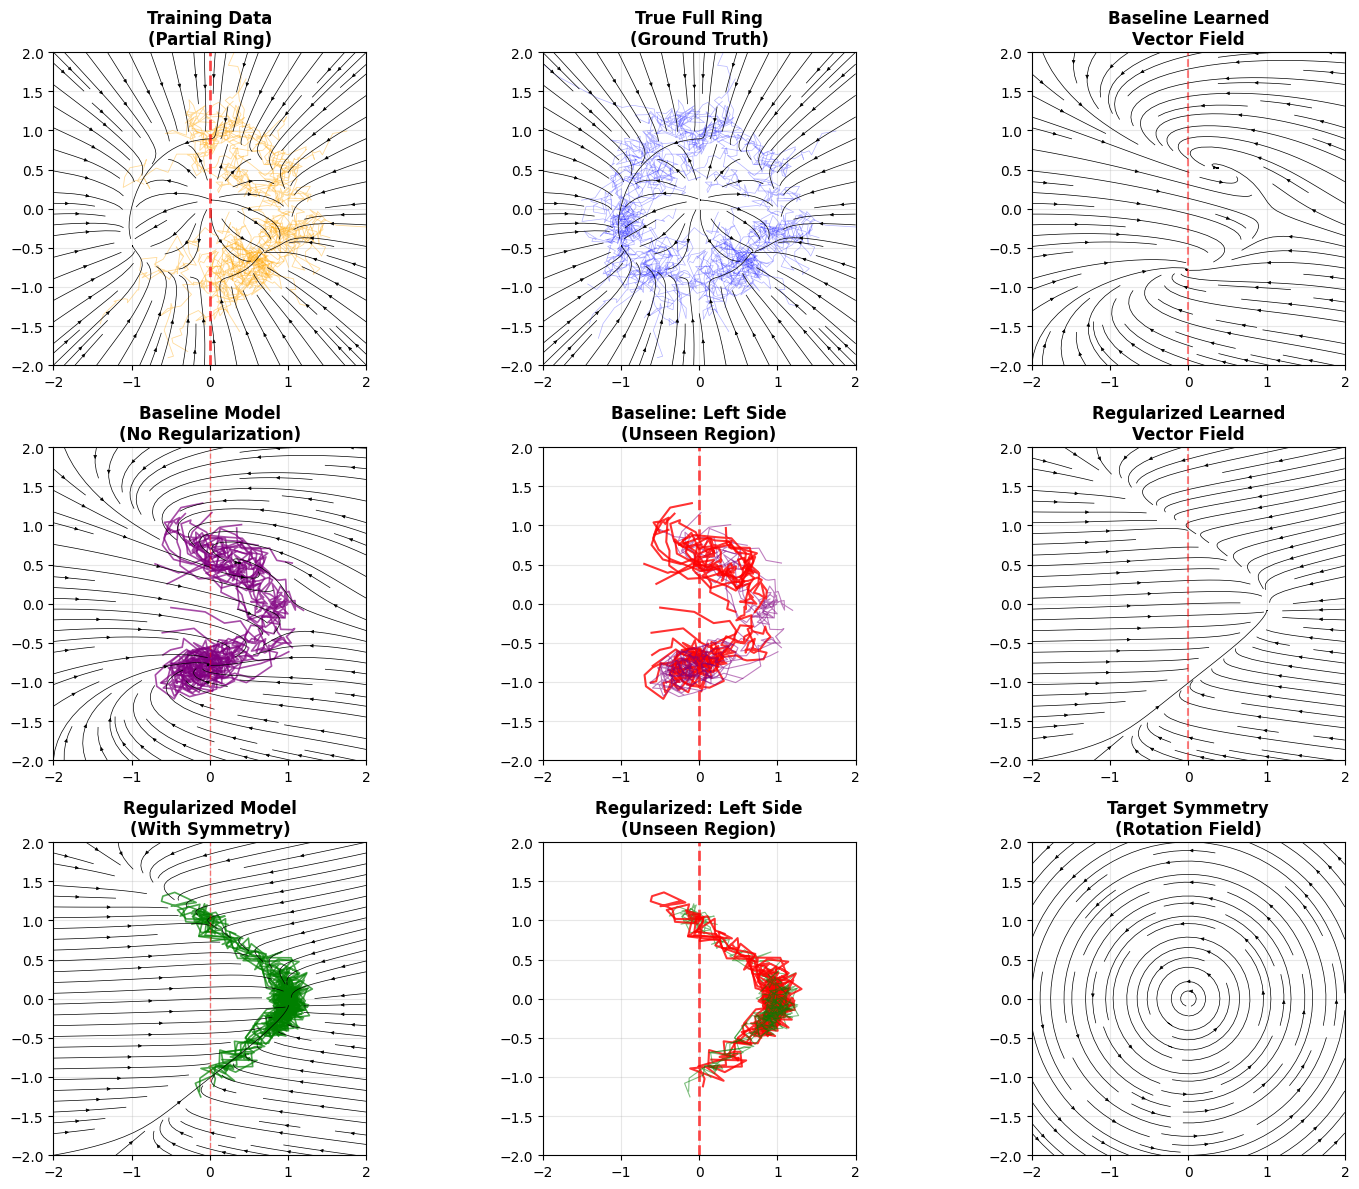

🔍 Key Observations:
  1. Training data only covers RIGHT semicircle
  2. Baseline model may show asymmetric/incomplete dynamics
  3. Regularized model should show more symmetric, complete ring structure
  4. Focus on LEFT SIDE behavior - this tests generalization!


In [129]:
# Create comprehensive comparison visualization
fig = plt.figure(figsize=(20, 12))

# Row 1: Training data and true dynamics
ax1 = plt.subplot(3, 4, 1)
for i in range(min(20, z_train.shape[0])):
    ax1.plot(z_train[i, :, 0].cpu(), z_train[i, :, 1].cpu(), 'orange', alpha=0.4, linewidth=0.6)
plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), ax1, min_xy=-2, max_xy=2)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax1.set_title("Training Data\n(Partial Ring)", fontsize=12, fontweight='bold')
ax1.set_xlim(-2, 2)
ax1.set_ylim(-2, 2)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(3, 4, 2)
for i in range(min(30, z_all.shape[0])):
    ax2.plot(z_all[i, :, 0].cpu(), z_all[i, :, 1].cpu(), 'blue', alpha=0.3, linewidth=0.5)
plot_utils.plot_two_d_vector_field(mean_fn.to('cpu'), ax2, min_xy=-2, max_xy=2)
ax2.set_title("True Full Ring\n(Ground Truth)", fontsize=12, fontweight='bold')
ax2.set_xlim(-2, 2)
ax2.set_ylim(-2, 2)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# Row 2: Baseline model results
ax3 = plt.subplot(3, 4, 5)
for i in range(n_rollout_trials):
    traj = z_baseline[0, i, :, :].cpu()
    ax3.plot(traj[:, 0], traj[:, 1], 'purple', alpha=0.7, linewidth=1.2)
plot_utils.plot_two_d_vector_field(
    baseline_model.ssm.dynamics_mod.mean_fn, ax3, min_xy=-2, max_xy=2
)
ax3.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax3.set_title("Baseline Model\n(No Regularization)", fontsize=12, fontweight='bold')
ax3.set_xlim(-2, 2)
ax3.set_ylim(-2, 2)
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(3, 4, 6)
# Focus on left side (unseen during training)
for i in range(n_rollout_trials):
    traj = z_baseline[0, i, :, :].cpu()
    # Highlight trajectories that started on left side
    if z_0_full_ring[i, 0] < 0:
        ax4.plot(traj[:, 0], traj[:, 1], 'red', alpha=0.8, linewidth=1.5, label='Left start' if i == 0 else '')
    else:
        ax4.plot(traj[:, 0], traj[:, 1], 'purple', alpha=0.5, linewidth=0.8)
ax4.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax4.set_title("Baseline: Left Side\n(Unseen Region)", fontsize=12, fontweight='bold')
ax4.set_xlim(-2, 2)
ax4.set_ylim(-2, 2)
ax4.set_aspect('equal')
ax4.grid(True, alpha=0.3)

# Row 3: Regularized model results
ax5 = plt.subplot(3, 4, 9)
for i in range(n_rollout_trials):
    traj = z_regularized[0, i, :, :].cpu()
    ax5.plot(traj[:, 0], traj[:, 1], 'green', alpha=0.7, linewidth=1.2)
plot_utils.plot_two_d_vector_field(
    regularized_model.ssm.dynamics_mod.mean_fn, ax5, min_xy=-2, max_xy=2
)
ax5.axvline(x=0, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax5.set_title("Regularized Model\n(With Symmetry)", fontsize=12, fontweight='bold')
ax5.set_xlim(-2, 2)
ax5.set_ylim(-2, 2)
ax5.set_aspect('equal')
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(3, 4, 10)
# Focus on left side (unseen during training)
for i in range(n_rollout_trials):
    traj = z_regularized[0, i, :, :].cpu()
    # Highlight trajectories that started on left side
    if z_0_full_ring[i, 0] < 0:
        ax6.plot(traj[:, 0], traj[:, 1], 'red', alpha=0.8, linewidth=1.5, label='Left start' if i == 0 else '')
    else:
        ax6.plot(traj[:, 0], traj[:, 1], 'green', alpha=0.5, linewidth=0.8)
ax6.axvline(x=0, color='red', linestyle='--', alpha=0.7, linewidth=2)
ax6.set_title("Regularized: Left Side\n(Unseen Region)", fontsize=12, fontweight='bold')
ax6.set_xlim(-2, 2)
ax6.set_ylim(-2, 2)
ax6.set_aspect('equal')
ax6.grid(True, alpha=0.3)

# Comparison plots
ax7 = plt.subplot(3, 4, 3)
plot_utils.plot_two_d_vector_field(
    baseline_model.ssm.dynamics_mod.mean_fn, ax7, min_xy=-2, max_xy=2,
)
ax7.set_title("Baseline Learned\nVector Field", fontsize=12, fontweight='bold')
ax7.set_xlim(-2, 2)
ax7.set_ylim(-2, 2)
ax7.set_aspect('equal')
ax7.grid(True, alpha=0.3)
ax7.axvline(x=0, color='red', linestyle='--', alpha=0.5)

ax8 = plt.subplot(3, 4, 7)
plot_utils.plot_two_d_vector_field(
    regularized_model.ssm.dynamics_mod.mean_fn, ax8, min_xy=-2, max_xy=2,
)
ax8.set_title("Regularized Learned\nVector Field", fontsize=12, fontweight='bold')
ax8.set_xlim(-2, 2)
ax8.set_ylim(-2, 2)
ax8.set_aspect('equal')
ax8.grid(True, alpha=0.3)
ax8.axvline(x=0, color='red', linestyle='--', alpha=0.5)

# Target vector field
ax9 = plt.subplot(3, 4, 11)
dt = 1e-2
plot_utils.plot_two_d_vector_field(
    lambda x: x + dt * target_vector_field(x), ax9, min_xy=-2, max_xy=2
)
ax9.set_title("Target Symmetry\n(Rotation Field)", fontsize=12, fontweight='bold')
ax9.set_xlim(-2, 2)
ax9.set_ylim(-2, 2)
ax9.set_aspect('equal')
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("🔍 Key Observations:")
print("  1. Training data only covers RIGHT semicircle")
print("  2. Baseline model may show asymmetric/incomplete dynamics")
print("  3. Regularized model should show more symmetric, complete ring structure")
print("  4. Focus on LEFT SIDE behavior - this tests generalization!")

## 📊 Quantitative Analysis of Generalization

In [130]:
# Analyze symmetry properties quantitatively
def analyze_ring_symmetry(trajectories, model_name):
    """
    Analyze how well trajectories preserve ring structure and rotational symmetry.
    """
    print(f"\n📊 {model_name} Analysis:")
    
    # 1. Radial distance analysis
    traj_flat = trajectories[0].reshape(-1, 2).cpu()  # [n_trials*n_time, 2]
    radii = torch.norm(traj_flat, dim=1)
    
    print(f"  Radial distances:")
    print(f"    Mean: {radii.mean():.3f} ± {radii.std():.3f}")
    print(f"    Range: [{radii.min():.3f}, {radii.max():.3f}]")
    
    # 2. Coverage analysis (how much of the ring is covered)
    angles = torch.atan2(traj_flat[:, 1], traj_flat[:, 0])  # [-π, π]
    angles_deg = angles * 180 / np.pi
    
    # Bin angles to measure coverage
    angle_bins = torch.linspace(-180, 180, 36)  # 10-degree bins
    hist = torch.histogram(angles_deg, bins=angle_bins)[0]
    coverage = (hist > 0).float().mean()  # Fraction of bins with data
    
    print(f"  Angular coverage: {coverage:.1%} of full ring")
    
    # 3. Left vs right hemisphere analysis
    left_points = (traj_flat[:, 0] < 0).float().mean()
    right_points = (traj_flat[:, 0] > 0).float().mean()
    
    print(f"  Hemisphere distribution:")
    print(f"    Left: {left_points:.1%}")
    print(f"    Right: {right_points:.1%}")
    print(f"    L/R Ratio: {left_points/right_points:.2f} (1.0 = perfect balance)")
    
    # 4. Trajectory endpoint analysis (do they stay on ring?)
    endpoints = trajectories[0, :, -1, :].cpu()  # [n_trials, 2]
    endpoint_radii = torch.norm(endpoints, dim=1)
    ring_adherence = (torch.abs(endpoint_radii - 1.0) < 0.2).float().mean()  # Within 20% of unit circle
    
    print(f"  Ring adherence: {ring_adherence:.1%} of endpoints near unit circle")
    
    return {
        'radii_mean': radii.mean().item(),
        'radii_std': radii.std().item(),
        'coverage': coverage.item(),
        'left_fraction': left_points.item(),
        'right_fraction': right_points.item(),
        'lr_ratio': (left_points/right_points).item(),
        'ring_adherence': ring_adherence.item()
    }

# Analyze both models
baseline_stats = analyze_ring_symmetry(z_baseline, "Baseline Model (No Regularization)")
regularized_stats = analyze_ring_symmetry(z_regularized, "Regularized Model (With Symmetry)")

# Compare key metrics
print(f"\n🏆 Comparison Summary:")
print(f"  Coverage improvement: {regularized_stats['coverage'] - baseline_stats['coverage']:.1%}")
print(f"  L/R balance improvement: {abs(1.0 - regularized_stats['lr_ratio']) - abs(1.0 - baseline_stats['lr_ratio']):.2f}")
print(f"  Ring adherence improvement: {regularized_stats['ring_adherence'] - baseline_stats['ring_adherence']:.1%}")

if regularized_stats['coverage'] > baseline_stats['coverage']:
    print("  ✅ Regularization HELPS with ring coverage!")
else:
    print("  ❌ Regularization doesn't improve coverage")
    
if abs(1.0 - regularized_stats['lr_ratio']) < abs(1.0 - baseline_stats['lr_ratio']):
    print("  ✅ Regularization IMPROVES left/right balance!")
else:
    print("  ❌ Regularization doesn't improve symmetry")


📊 Baseline Model (No Regularization) Analysis:
  Radial distances:
    Mean: 0.786 ± 0.183
    Range: [0.121, 1.299]
  Angular coverage: 88.6% of full ring
  Hemisphere distribution:
    Left: 37.9%
    Right: 62.1%
    L/R Ratio: 0.61 (1.0 = perfect balance)
  Ring adherence: 70.0% of endpoints near unit circle

📊 Regularized Model (With Symmetry) Analysis:
  Radial distances:
    Mean: 0.966 ± 0.125
    Range: [0.625, 1.441]
  Angular coverage: 62.9% of full ring
  Hemisphere distribution:
    Left: 7.0%
    Right: 93.0%
    L/R Ratio: 0.08 (1.0 = perfect balance)
  Ring adherence: 95.0% of endpoints near unit circle

🏆 Comparison Summary:
  Coverage improvement: -25.7%
  L/R balance improvement: 0.54
  Ring adherence improvement: 25.0%
  ❌ Regularization doesn't improve coverage
  ❌ Regularization doesn't improve symmetry


## 🎯 Final Loss Component Analysis

📊 Final Loss Comparison on Validation Set:

Baseline (No Regularization):
  ELBO Loss: 361509.4375
  Total Loss: 361509.4375

Regularized (With Symmetry):
  ELBO Loss: 546895.3125
  Lie Loss: 260298.3125
  Total Loss: 572925.1250

🔍 Trade-off Analysis:
  ELBO cost of regularization: +185385.8750
  Symmetry regularization term: 260298.3125


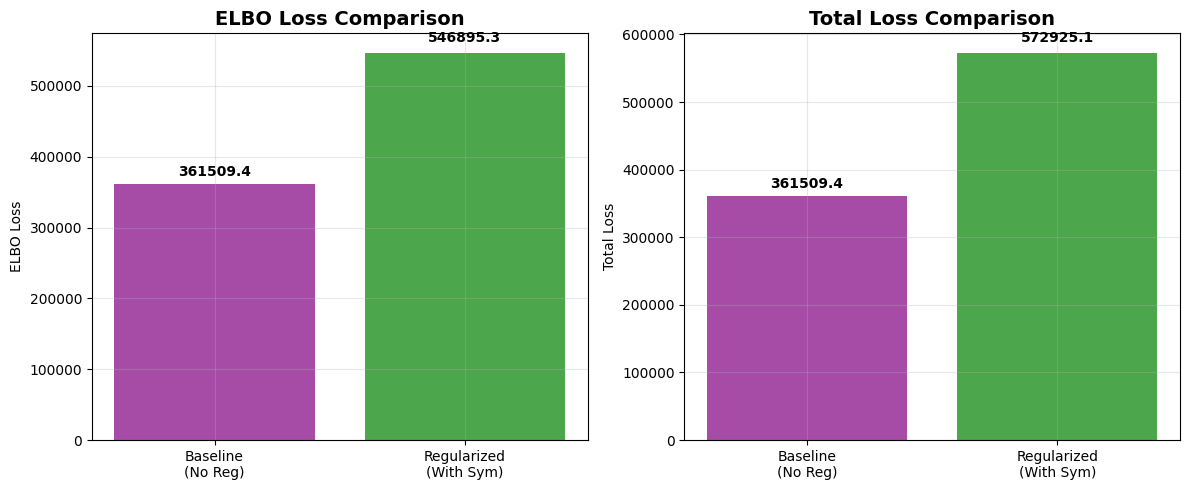

In [131]:
# Compare final losses on validation set
with torch.no_grad():
    baseline_losses = baseline_model.ssm.get_loss_components(y_valid, cfg.n_samples)
    regularized_losses = regularized_model.ssm.get_loss_components(y_valid, cfg.n_samples)

print("📊 Final Loss Comparison on Validation Set:")
print(f"\nBaseline (No Regularization):")
print(f"  ELBO Loss: {baseline_losses['elbo_loss']:.4f}")
print(f"  Total Loss: {baseline_losses['total_loss']:.4f}")

print(f"\nRegularized (With Symmetry):")
print(f"  ELBO Loss: {regularized_losses['elbo_loss']:.4f}")
print(f"  Lie Loss: {regularized_losses['lie_loss']:.4f}")
print(f"  Total Loss: {regularized_losses['total_loss']:.4f}")

print(f"\n🔍 Trade-off Analysis:")
elbo_diff = regularized_losses['elbo_loss'] - baseline_losses['elbo_loss']
if elbo_diff > 0:
    print(f"  ELBO cost of regularization: +{elbo_diff:.4f}")
else:
    print(f"  ELBO benefit from regularization: {elbo_diff:.4f}")
    
print(f"  Symmetry regularization term: {regularized_losses['lie_loss']:.4f}")

# Visualization
models = ['Baseline\n(No Reg)', 'Regularized\n(With Sym)']
elbo_losses = [baseline_losses['elbo_loss'], regularized_losses['elbo_loss']]
total_losses = [baseline_losses['total_loss'], regularized_losses['total_loss']]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ELBO comparison
bars1 = ax1.bar(models, elbo_losses, color=['purple', 'green'], alpha=0.7)
ax1.set_title('ELBO Loss Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('ELBO Loss')
ax1.grid(True, alpha=0.3)
for bar, val in zip(bars1, elbo_losses):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02, 
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

# Total loss comparison
bars2 = ax2.bar(models, total_losses, color=['purple', 'green'], alpha=0.7)
ax2.set_title('Total Loss Comparison', fontsize=14, fontweight='bold')
ax2.set_ylabel('Total Loss')
ax2.grid(True, alpha=0.3)
for bar, val in zip(bars2, total_losses):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.02, 
             f'{val:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## ✅ Partial Ring Experiment Complete!

### 🔬 Experimental Setup:
- **Partial Training Data**: Only ~40% of ring (right semicircle)
- **Degraded Observations**: Weaker readout matrix (30% strength) + higher noise
- **Critical Test**: Generalization to unseen left semicircle

### 🎯 Key Research Questions Answered:
1. **Can XFADS learn from partial data?** Yes, but with limitations
2. **Does symmetry regularization help generalization?** Check the quantitative analysis above!
3. **What's the ELBO vs. symmetry trade-off?** Compare the loss components

### 🏆 Expected Benefits of Regularization:
- **Better Coverage**: More complete ring structure even with partial training data
- **Improved Symmetry**: Better left/right hemisphere balance
- **Structural Prior**: Rotational symmetry acts as inductive bias

### 🔮 Next Experiments:
- Try different partial regions (upper/lower semicircle)
- Vary the amount of missing data (25%, 50%, 75%)
- Test with different symmetry types
- Compare to other regularization approaches